In [1]:
from my_dataset import EqDataset
from CNNmodel import OURCNN
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
# from ten
# sorboardX import  SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)


In [16]:
MAX_EPOCH = 10
BATCH_SIZE = 256
#256
val_interval = 50
log_interval = 100
TRAIN_START = 1993
TRAIN_END = 2000

# ============================ step 1/5 data ============================
train_transform = transforms.Compose([transforms.ToTensor()])
t_v_data = EqDataset(data_dir="/home/clicw/data/MAFS6010Z_Project2/data/",sd=TRAIN_START,ed=TRAIN_END,transform=train_transform)
train_size = int(0.7 * len(t_v_data))
validate_size = len(t_v_data) - train_size
train_dataset, validate_dataset = torch.utils.data.random_split(t_v_data, [train_size, validate_size])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                        shuffle=True)
validateloader = torch.utils.data.DataLoader(validate_dataset, batch_size=BATCH_SIZE,
                                        shuffle=False)

# ============================ step 2/5 model ============================
net = OURCNN()
net.cuda()

# ============================ step 3/5 loss ============================
criterion = nn.CrossEntropyLoss()

# ============================ step 4/5 optim ============================
optimizer = optim.SGD(net.parameters(), lr=0.00005)                        # 选择优化器

# ============================ step 5/5 train ============================
train_curve = list()
valid_curve = list()

iter_count = 0

# SummaryWriter
# writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.
    correct_this_time = 0.
    total_this_time = 0.

    net.train()
    # 遍历 train_loader 取数据
    for i, data in enumerate(trainloader):
        iter_count = iter_count+1
        # forward
        inputs, labels = data
        labels = labels.squeeze(1).long()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        # backward
        optimizer.zero_grad()
        #temp = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        loss.backward()
        # update weights
        optimizer.step()

        # get score
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().cpu().numpy()
        
        # print
        loss_mean += loss.item()
        train_curve.append(loss.item())

        correct_this_time = correct_this_time + (predicted == labels).squeeze().sum().cpu().numpy()
        total_this_time = total_this_time + labels.size(0)

        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%} Acc_total:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(trainloader), loss_mean,correct_this_time/total_this_time,correct / total))
            loss_mean = 0.
            correct_this_time = 0.
            total_this_time = 0.

        # # 记录数据，保存于event file
        # writer.add_scalars("Loss", {"Train": loss.item()}, iter_count)
        # writer.add_scalars("Accuracy", {"Train": correct / total}, iter_count)

    # # Each epoch，write weights and grad
    # for name, param in net.named_parameters():
    #     writer.add_histogram(name + '_grad', param.grad, epoch)
    #     writer.add_histogram(name + '_data', param, epoch)

        # validate the model
        if (i+1) % val_interval == 0:
            correct_val = 0.
            total_val = 0.
            loss_val = 0.
            net.eval()
            with torch.no_grad():
                for j, data in enumerate(validateloader):
                    inputs, labels = data
                    labels = labels.squeeze(1).long()
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).squeeze().sum().cpu().numpy()

                    loss_val += loss.item()

                valid_curve.append(loss_val/validateloader.__len__())

                print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration_train[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                    epoch, MAX_EPOCH, i+1, len(trainloader),j+1, len(validateloader), loss_val, correct_val / total_val))

            if len(valid_curve)>=3 and valid_curve[-1]>valid_curve[-2] and valid_curve[-2]>valid_curve[-3]:
                break

        if len(valid_curve)>=3 and valid_curve[-1]>valid_curve[-2] and valid_curve[-2]>valid_curve[-3]:
            print('====================================================================')
            print('Valid[-1] Loss: {:.4f} Valid[-2] Loss: {:.4f} Valid[-3] Loss: {:.4f}'.format(
                valid_curve[-1],valid_curve[-2],valid_curve[-3]))
            break

            # writer.add_scalars("Loss", {"Valid": np.mean(valid_curve)}, iter_count)
            # writer.add_scalars("Accuracy", {"Valid": correct / total}, iter_count)

Valid:	 Epoch[000/010] Iteration_train[050/1901] Iteration[815/815] Loss: 575.7151 Acc:50.28%
Training:Epoch[000/010] Iteration[100/1901] Loss: 0.8433 Acc:49.81% Acc_total:49.81%
Valid:	 Epoch[000/010] Iteration_train[100/1901] Iteration[815/815] Loss: 575.2933 Acc:50.40%
Valid:	 Epoch[000/010] Iteration_train[150/1901] Iteration[815/815] Loss: 575.0307 Acc:50.41%
Training:Epoch[000/010] Iteration[200/1901] Loss: 0.7046 Acc:50.72% Acc_total:50.26%
Valid:	 Epoch[000/010] Iteration_train[200/1901] Iteration[815/815] Loss: 574.9983 Acc:50.26%
Valid:	 Epoch[000/010] Iteration_train[250/1901] Iteration[815/815] Loss: 574.6209 Acc:50.45%
Training:Epoch[000/010] Iteration[300/1901] Loss: 0.7056 Acc:50.30% Acc_total:50.28%
Valid:	 Epoch[000/010] Iteration_train[300/1901] Iteration[815/815] Loss: 575.9135 Acc:50.96%
Valid:	 Epoch[000/010] Iteration_train[350/1901] Iteration[815/815] Loss: 574.7340 Acc:50.86%
Training:Epoch[000/010] Iteration[400/1901] Loss: 0.7053 Acc:50.36% Acc_total:50.30%
Va

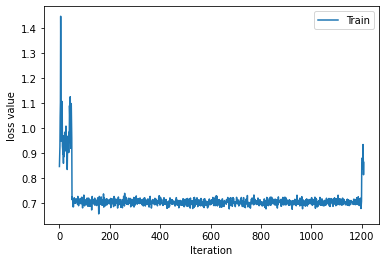

In [17]:

train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(trainloader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
# plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()


In [18]:
# ============================ step 1/5 data ============================
test_transform = transforms.Compose([transforms.ToTensor()])
test_data = EqDataset(data_dir="/home/clicw/data/MAFS6010Z_Project2/data/",sd=2000,ed=2020,transform=train_transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,
                                        shuffle=False)

In [19]:
correct_test = 0.
total_test = 0.
loss_test = 0.
test_curve=[]
net.eval()
with torch.no_grad():
    for j, data in enumerate(testloader):
        inputs, labels = data
        labels = labels.squeeze(1).long()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).squeeze().sum().cpu().numpy()

        loss_mean += loss.item()
        test_curve.append(loss.item())

        if (j+1) % log_interval == 0:
                loss_mean = loss_mean / log_interval
                print("Testing: Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                    j+1, len(testloader), loss_mean, correct_test / total_test))
                loss_mean = 0.

Testing: Iteration[100/5868] Loss: 0.7286 Acc:49.73%
Testing: Iteration[200/5868] Loss: 0.7143 Acc:50.10%
Testing: Iteration[300/5868] Loss: 0.7185 Acc:50.07%
Testing: Iteration[400/5868] Loss: 0.7220 Acc:49.89%
Testing: Iteration[500/5868] Loss: 0.7191 Acc:49.92%
Testing: Iteration[600/5868] Loss: 0.7181 Acc:49.90%
Testing: Iteration[700/5868] Loss: 0.7192 Acc:49.86%
Testing: Iteration[800/5868] Loss: 0.7220 Acc:49.78%
Testing: Iteration[900/5868] Loss: 0.7223 Acc:49.73%
Testing: Iteration[1000/5868] Loss: 0.7221 Acc:49.69%
Testing: Iteration[1100/5868] Loss: 0.7187 Acc:49.71%
Testing: Iteration[1200/5868] Loss: 0.7012 Acc:49.99%
Testing: Iteration[1300/5868] Loss: 0.7067 Acc:50.12%
Testing: Iteration[1400/5868] Loss: 0.7068 Acc:50.25%
Testing: Iteration[1500/5868] Loss: 0.7152 Acc:50.27%
Testing: Iteration[1600/5868] Loss: 0.7138 Acc:50.31%
Testing: Iteration[1700/5868] Loss: 0.7129 Acc:50.37%
Testing: Iteration[1800/5868] Loss: 0.7129 Acc:50.39%
Testing: Iteration[1900/5868] Loss: 0

In [20]:
correct_test / total_test

0.5037590130768252